# Taming text

In [3]:
%matplotlib inline
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from wordcloud import WordCloud
from PIL import Image

import nltk
import string

import pycountry
from nltk.sentiment.util import *

from tqdm import tqdm

%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1) Word cloud from the corpus

In this first part we want to extract from Mrs Clinton emails a word cloud. 

### 1.1) Data extraction

In [4]:
path = 'hillary-clinton-emails/'
emails = pd.read_csv(path + "Emails.csv")
emails.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


It seems that we are provided with either the raw text file or an "attempt at extracting the body" of the message. We compare them on one instance to understand them better.

In [5]:
print(emails.head()["RawText"][1])

UNCLASSIFIED
U.S. Department of State
Case No. F-2015-04841
Doc No. C05739546
Date: 05/13/2015
STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.
SUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.
RELEASE IN
PART B6
From:
Sent:
To:
Subject:
Attachments:
B6
Thursday, March 3, 2011 9:45 PM
H: Latest How Syria is aiding Qaddafi and more... Sid
hrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx
CONFIDENTIAL
March 3, 2011
For: Hillary
From: Sid
Re: Syria aiding Qaddafi
This memo has two parts. Part one is the report that Syria is providing air support for Qaddafi. Part two is a note
to Cody from Lord David Owen, former UK foreign secretary on his views of an increasingly complex crisis. It
seems that the situation is developing into a protracted civil war with various nations backing opposing sides
with unforeseen consequences. Under these circumstances the crucial challenge is to deprive Qaddafi of his
strategic depth—his support bo

In [6]:
print(emails.head()["ExtractedBodyText"][1])

B6
Thursday, March 3, 2011 9:45 PM
H: Latest How Syria is aiding Qaddafi and more... Sid
hrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx
March 3, 2011
For: Hillary



I hate rapid conclusion but it feels as if the Extracted Body Text feature won't get us far. We thus create a new data frame to process.

In [7]:
emails_rawtext = emails["RawText"]
emails_rawtext.head()

0    UNCLASSIFIED\nU.S. Department of State\nCase N...
1    UNCLASSIFIED\nU.S. Department of State\nCase N...
2    UNCLASSIFIED\nU.S. Department of State\nCase N...
3    UNCLASSIFIED\nU.S. Department of State\nCase N...
4    B6\nUNCLASSIFIED\nU.S. Department of State\nCa...
Name: RawText, dtype: object

We finally extract the corpus

In [8]:
raw_corpus = emails_rawtext.str.cat(sep=" ")

### 1.2) Initial wordcloud

Defining the wordcloud generation

In [9]:
def generate_wordcloud(text):
    mask = np.array(Image.open("trumpmask.jpg"))
    return WordCloud(background_color="white", mask=mask).generate(text)

Plot wordcloud for raw corpus

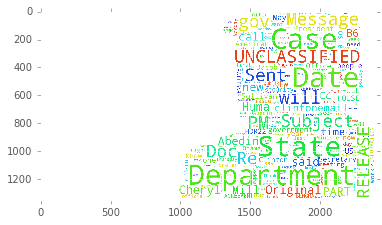

In [10]:
raw_wordcloud = generate_wordcloud(raw_corpus)
plt.imshow(raw_wordcloud)
plt.show()

### 1.3) Data processing

Defining the preprocessing pipeline

In [11]:
def preprocessing(raw, add_stopwords=[], verbose=False):
    # Tokenization
    if verbose:
        print("Tokenization...")
    punctuations = list(string.punctuation)
    tokens = nltk.word_tokenize(raw)
    tokenized = [token.lower() for token in tokens if token not in punctuations]
    
    # Stopword removal
    if verbose:
        print("Stopword removal...")
    stop_filter = nltk.corpus.stopwords.words('english')
    stop_filter.extend(add_stopwords)
    filtered = [word for word in tokenized if word not in stop_filter]
    
    # Lemmatisation
    if verbose:
        print("Lemmatization...")
    wnl = nltk.stem.wordnet.WordNetLemmatizer()
    #lemmatized = [wnl.lemmatize(word) for word in filtered]
    lemmatized = [wnl.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] else wnl.lemmatize(i) for i,j in nltk.pos_tag(filtered)]
    
    return lemmatized

Preprocess corpus and save to file (**not necessary to run cell bellow since super long**)

In [15]:
#stopwords = ["unclassified", "send", "state", "department", "date", "subject", "message"]
#preprocessed_corpus = preprocessing(raw_corpus, add_stopwords=stopwords, verbose=True)

#corpus_file = open("processed_corpus.txt", 'w')
#for word in preprocessed_corpus:
#    corpus_file.write("%s\n" % word)

Tokenization...
Stopword removal...
Lemmatization...


In [24]:
def stopword_removal(raw, add_stopwords=[]):
    filtered = [word for word in raw if word not in add_stopwords]
    return filtered

Here we reload the initial filtering that was done and we further remove words identified as generic mail things. We also want to identify discriminating words, and remove any high frequency one.

In [44]:
preprocessed_corpus = [line.rstrip('\n') for line in open('processed_corpus.txt')]
stopwords = ["state", "pm", "call", "send", "new", "doc", "gov", "release", "part", "in", "doc",
             "no", "gov", "b6", "time", "original", "say", "from", "sent", "to", "subject", "attachments",
            "monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday", "january", "february",
            "march", "april", "may", "june", "july", "august", "september", "october", "november", "december", "case"]
preprocessed_corpus = stopword_removal(preprocessed_corpus, stopwords)

Load preprocessed_corpus

In [49]:
import re
digits = re.compile(r'[\'-.?!,":;()|0-9]')
preprocessed_corpus = [digits.sub("", word) for word in preprocessed_corpus]   
preprocessed_corpus = list(filter(None, preprocessed_corpus)) # remove empty strings

In [59]:
stopwords = ["us", "c", "f", "//", "``", "h", "s", "u", "stategov", "would", "b", "j", "cc"]
preprocessed_corpus = stopword_removal(preprocessed_corpus, stopwords)

In [ ]:
corpus_str = ' '.join(preprocessed_corpus)
preprocessed_wordcloud = generate_wordcloud(corpus_str)
plt.imshow(preprocessed_wordcloud)
plt.show()

They are words that appear in each email and they are not very relevant. 

In [ ]:
fd = nltk.FreqDist(preprocessed_corpus)
fd.plot(30, cumulative=False)

## Mentions of world countries in the whole corpus

In [225]:
country_names = [country.name.lower() for country in pycountry.countries]   
country_codes = [country.alpha_2 for country in pycountry.countries]

def country_mentions(text):
    prepro = preprocessing(text)
    
    matches = []
    for k in range(len(country_names)):
        matches.extend([word for word in prepro if word == country_names[k]])
        matches.extend([country_names[k] for word in prepro if word == country_codes[k]])
    
    return list(set(matches))

Find mentions of world countries (**takes ~5 min to run**)

In [226]:
#mentions = emails_rawtext.apply(country_mentions)
tqdm.pandas(desc="Extracting mentions of country")
mentions = emails_rawtext.progress_apply(country_mentions)

Extracting mentions of country: 100%|██████████| 7945/7945 [03:21<00:00, 39.47it/s]


In [228]:
mentions.head(10)

0                                                   []
1    [lebanon, egypt, israel, france, spain, libya,...
2                                                   []
3                                                   []
4    [lebanon, egypt, israel, france, spain, libya,...
5                                                   []
6                    [libya, iraq, afghanistan, egypt]
7    [lebanon, egypt, israel, france, spain, libya,...
8                                     [morocco, libya]
9            [sudan, libya, afghanistan, yemen, egypt]
Name: RawText, dtype: object